In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

Every instance of the dataset for supervised learning consist of two parts:

1. **Input features** are different values that are used to perform inference and make decisions. Initially these values might be represented by any data type, but before puting them into model, needs to be transformed into numerical formats.
$$
i \in \mathbb{R}^{\text{\# features}}
$$

2. **Targets** are the actual values that the model needs to predict, given the input.
$$
t \in \mathbb{R}^{\text{\# outputs}}
$$

For this assignment The single label classification dataset from Kaggle will be used.

In [90]:
df = pd.read_csv("./data/drug200.csv.xls")

In [91]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.35500,drugY
1,47,M,LOW,HIGH,13.09300,drugC
2,47,M,LOW,HIGH,10.11400,drugC
3,28,F,NORMAL,HIGH,7.79800,drugX
4,61,F,LOW,HIGH,18.04300,drugY


In [94]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.35500,drugY
1,47,M,LOW,HIGH,13.09300,drugC
2,47,M,LOW,HIGH,10.11400,drugC
3,28,F,NORMAL,HIGH,7.79800,drugX
4,61,F,LOW,HIGH,18.04300,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.56700,drugC
196,16,M,LOW,HIGH,12.00600,drugC
197,52,M,NORMAL,HIGH,9.89400,drugX
198,23,M,NORMAL,NORMAL,14.02000,drugX


# Model
In the most basic overview ANN consist of multiple layers with same structure. These layers are defined with the parameters weights matrix $W$ and bias vector $b$. The structure of each layer looks as follows:

- **Fully connected** layer servers as main place of computation in the basic ANN.
$$
z^{(l)} = W^{(l)}a^{(l-1)} + b^{(l)}
$$
Where $W \in \mathbb{R}^{\text{\# inputs} \times \text{\# outputs}}$ and $b \in \mathbb{R}^{\text{\# outputs}}$ are learnable.

- **Activation function** is the next step after linear transformation. Activation function should be non-linear, since otherwise all the model will be just the composition of linear transformation, which is equivalent to single matrix multiplication, which is obviously not capable to cover some dependencies of the inputs.
Here the ReLu function will be used:

$$
a = \text{ReLU}(z)
$$

$$
\text{ReLU}(z) =
\begin{cases}
z, & \text{if } z > 0 \\
0, & \text{if } z \leq 0
\end{cases}
$$

- **Output layer** of the model depends on the task, for classification, the last layer should have number of nodes equal to number of classes in the dataset.
    After all the previous layers done, these nodes will take some raw numbers as the result of all previous computations, which are called logits.
    Since the task is classification, we want to get the probability distribution of every class given input $P(x = c | input), \quad \text{for }c = 1,2, \cdots, n $. The probability distribution should follow main rules:
  The probability distribution should follow main rules:

$$
1. \text{Non-negativity: } P(x) \geq 0, \quad \forall x
$$

$$
2. \text{Normalization: } \sum_x P(x) = 1 \quad \text{(discrete case)} \quad \text{or} \quad \int P(x) dx = 1 \quad \text{(continuous case)}
$$

In case of single label classification the softmax function is used to get the distribution from logits:
$$
\text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{i} e^{z_i}}
$$

For numerical stability, we also want to subtract $\text{max}{(z)}$ before applying softmax.

After all steps reviewed we could asemble the Model architecture, we will have 1 hidden layer and 3 output classes:

<img src="math/architecture.jpg" alt="Local Image" width="1000">


# Training

The key idea how the model train in the supervised approach requires few concepts that will be covered in this section.
The high level idea is to use actual target $y$ for given instance and predicted value $\hat y$ and compute $Loss(y,\hat y)$ some function that outputs measure of how good the model predicted this instance, then we could use calculus to compute how to change model parameters to minimize the Loss function.

## Cross-Entropy
Cross-Entropy is general idea that allows to numerically estimate how much two distributions align.

To build intuition about this concept, let's introduce the idea of **surprise**:

1. We experience **more surprise** when we sample a **rare event** and **less surprise** when an event has a **high probability**. This suggests that surprise is **inversely proportional to probability**.
2. Additionally, if we sample a rare event **twice**, our surprise should **double**.

#### Formalizing Surprise

Suppose we define surprise as $s(x)$, and consider an event $x = a$ with probability:

$$
p(x = a) = 0.2
$$

If the surprise for this event is:

$$
s(x = a) = m
$$

Then, if we sample the same event twice:

$$
p(x = a \cap x = a) = 0.2^2 = 0.04
$$

The corresponding surprise should double:

$$
s(x = a \cap x = a) = 2m
$$

Since multiplication of probabilities corresponds to **addition of surprises**, a natural definition of surprise is:

$$
s(x) = \log p(\frac{1}{x})
$$

Once we have the idea of surprise defined, we could move to the Entropy.

The value of Entropy might be seen as expected surprise measure of the distribution:

$$
H(P) = \mathbb {E}[log(\frac{1}{p})] = \sum_i{p_i \cdot \log \frac{1}{p_i}}
$$

Generally this value is not too big, since we kind of weight the surprise with probability and "know what to expect". When we know all the underlying distribution the computed surprise for every even is computed according to its actual probability.

This concept alone is not so powerful, but it allows us to introduce the tool that measures how good some Distribution $Q$ estimates the average surprise, when sampling from Distribution P, this is called Cross-Entropy.

## Cross-Entropy
Cross-Entropy is the function of 2 Probability Distributions that quantifies the expectation of surprise, when observing the random process generated from $P$ but believing it comes from $Q$.

$$
H(P,Q) = \sum_i{p_i \cdot \log \frac{1}{q_i}}
$$

When we consider the $H(P,P)$ it naturally equals to just entropy of $P$:

$$
H(P,P) = \sum_i{p_i \cdot \log \frac{1}{p_i}} = H(P)
$$

The key property that I won't be proving here is that:

$$
\forall Q,P : H(P) \leq H(P,Q)
$$

For any mode lthe Cross-Entropy can never be lower than the Entropy of the underlying distribution.

---
### Additional Notes
Also considering the topic of the Cross-Entropy I want to mention the idea of Kullback–Leibler Divergence, this idea allows to measure how much the $H(P,Q)$ differs from $H(P)$.

$$
H(P,Q) = \sum_i{p_i \cdot \log \frac{1}{q_i}}
$$

$$
H(P) = \sum_i{p_i \cdot \log \frac{1}{p_i}}
$$

Then the formula for KL Divergence looks as:

$$
\begin{align}
\mathcal{D}_{KL} &= H(P,Q) - H(P) = \\
    &= \sum_i{p_s(\log \frac{1}{q_i} - \log \frac{1}{p_i})} = \\
    &= \sum_i{p_s \log \frac{p_i}{q_i}}
\end{align}
$$

However, for our case it is not useful since:

$$
\mathcal{D}_{KL} = H(P,Q) - H(P)
$$

The P is underlaying distribution and it doesn't depend on the model parameters, so minimizing the $\mathcal{D}_{KL}$ is equivalent to $H(P,Q)$.



## Complete Loss Function

Now we have discussed all the concepts to set up the Loss Function for the training process, we could simply use the Cross-Entropy, but since we are dealing with single label classification, we could perform one step that will simplify future math derivations.

Firstly lets denote concreate variables we are going to use:

$$
\begin{aligned}
t &- \text{encoded value of actual class} \\
\hat{y} &- \text{vector of predicted probabilities for each class, where } \hat{y}_i = \text{probability of class } i
\end{aligned}
$$

Using these notation the formula for Loss will look as follows:

$$
Loss(t, \hat y) = \sum_s p_s \log {\frac{1}{\hat y_s}}
$$

In our case the $P$ is described with actual value $t$ in every sample, meaning we have $e_t(i) =
\begin{cases}
1, & \text{if } i = t \\
0, & \text{otherwise}
\end{cases}$, where $t$ is actual ground-truth and all other items are $0$.

So using this detailed the Loss function might be simplified to:

$$
Loss(t, \hat y) = \log {\frac{1}{\hat y_t}}
$$

To simplify future derivations, rewrite the log:

$$
Loss(t, \hat y) = - \log {\hat y_t}
$$

This means for each train sample to loss  is just the nagative logarithm of the target class probability. This formula is called Negative Log Likelihood which is final loss function for training process(not considering the regularization terms).

# A bit of Math

Now we could move to the derivation of model params in training process, the next step is to apply chain rule and find:

$$
\frac{\partial L}{\partial W^{(l)}},\frac{\partial L}{\partial b^{(l)}}, \quad \text{for each layer } l
$$

These partial derivatives shows how the change in the weight effect the value of loss, the gradient represents the vector of the fastest growth, since the optimization mostly consider minimization task, we will consider moving gradually changing the value of parameters in the opposite direction of the gradient.


## Chain Rule

To find the value of weights and bias, we need:

$$
\frac{\partial L}{\partial W^3} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z} \cdot \frac{\partial z}{\partial a_3} \cdot \frac{\partial a_3}{\partial W_3}
$$
$$
\frac{\partial L}{\partial b^3} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z} \cdot \frac{\partial z}{\partial a_3} \cdot \frac{\partial a_3}{\partial b_3}
$$

Firstly we want to compute value of $\frac{\partial L}{\partial z}$ so then we could directly move towards counting the actual gradient of model Params.

$$
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z}
$$


## 1. $\frac{\partial L}{\partial \hat y}$

let's consider variables and function that are used at this step:

$$
\begin{aligned}
&t - \text{encoded value of actual class} \\
&\hat{y} - \text{vector of predicted probabilities for each class, where } \hat{y}_i = \text{probability of class } i \\
&\text{Loss}(t, \hat{y}) = -\log \hat{y}_t
\end{aligned}
$$

Then it is clear that:
$$
\frac{\partial L}{\partial \hat y} = \begin{cases}
-\frac{1}{\hat y_i}, & \text{if } i = t \\
0, & \text{otherwise}
\end{cases}
$$


## 2. $\frac{\partial \hat y}{\partial z}$

Now we need to find $\frac{\partial \hat y}{\partial z}$ how the result of softmax $\hat y$ depends on the input $z$(logits).

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum e^{z_j}}, \quad \text{for } i = 1,2, \dots, n
$$

where we consider two cases: $i = k$ and $i \neq k$.

Also lets denote the denominator as:
$$
D = \sum e^{z_j}
$$

Then the softmax formula looks:
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{D}, \quad \text{for } i = 1,2, \dots, n
$$

### 2.1 $ i = k$

$$
\begin{aligned}
\frac{\partial \hat y_i}{\partial z_i} &= \frac{D \cdot \frac{\partial}{\partial z_i}e^{z_i} - e^{z_i}\cdot \frac{\partial}{\partial z_i}D}{D^2} = \frac{D \cdot e^{z_i} - (e^{z_i})^2}{D^2} = \\
&= \frac{e^{z_i} \cdot (D - e^{z_i})}{D^2} = \frac{e^{z_i}}{D} \cdot \frac{D - e^{z_i}}{D} = \hat y_i \cdot (1 - \hat y_i)
\end{aligned}
$$

So for this case:
$$
\frac{\partial \hat y_i}{\partial z_i} = \hat y_i \cdot (1 - \hat y_i)
$$

### 2.2 $i \neq k$

$$
\begin{aligned}
\frac{\partial \hat y_i}{\partial z_k} &= \frac{D \cdot \frac{\partial}{\partial z_k}e^{z_i} - e^{z_i}\cdot \frac{\partial}{\partial z_k}D}{D^2} = \frac{- e^{z_i} \cdot e^{z_k}}{D^2} = \\
&= \frac{- e^{z_i}}{D} \cdot \frac{e^{z_k}}{D} = - \hat y_i \cdot \hat y_k
\end{aligned}
$$

For this case:
$$
\frac{\partial \hat y_i}{\partial z_k} = - \hat y_i \cdot \hat y_k
$$

After covering these 2 cases, we could write the general formula for Jacobian of $\frac{\partial \hat y_i}{\partial z_k}$:

$$
\begin{aligned}
&\frac{\partial \hat y_i}{\partial z_k} = \hat y_i \cdot (\delta_{ik} - \hat y_k) \\
&\text{Where: } \delta_{ik} - \text{Krocker delta, meanining } \begin{cases}
1, & \text{if } i = k \\
0, & \text{otherwise}
\end{cases}
\end{aligned}
$$





## 3. $\frac{\partial L}{\partial z}$

Now the final step to finish the back propagation of Loss function is to chain $\frac{\partial L}{\partial z} = \frac{\partial L}{\partial\hat y} \cdot \frac{\partial \hat y}{\partial z}$

to properly apply chain rule, will transpose ${\frac{\partial \hat y}{\partial \hat y}}^T$ to get row-vector, then:
$$
\frac{\partial L}{\partial z} = {\frac{\partial \hat y}{\partial \hat y}}^T \cdot \frac{\partial \hat y}{\partial z}
$$

Then the operation looks:

$$
\frac{\partial L}{\partial z} = \begin{bmatrix} \frac{\partial L}{\partial \hat y_1} & \frac{\partial L}{\partial \hat y_2} & \cdots & \frac{\partial L}{\partial \hat y_n} \end{bmatrix}  \begin{bmatrix}
\frac{\partial \hat y_1}{\partial \hat z_1} & \frac{\partial \hat y_1}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_1}{\partial \hat z_n} \\
\frac{\partial \hat y_2}{\partial \hat z_1} & \frac{\partial \hat y_2}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_2}{\partial \hat z_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial \hat y_n}{\partial \hat z_1} & \frac{\partial \hat y_n}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_n}{\partial \hat z_n} \\
\end{bmatrix}
$$

then:
$$
\frac{\partial L}{\partial z_i} = \sum_j \frac{\partial L}{\partial \hat y_j} \cdot \frac{\partial \hat y_j}{\partial a_i}
$$

Since $\frac{\partial L}{\partial \hat y_j} = 0$ for every value of $j$ except the target class $j = t$:

$$
\frac{\partial L}{\partial z_i} = \frac{\partial L}{\partial \hat y_j} \cdot \frac{\partial \hat y_j}{\partial a_i} = - \frac{1}{\hat y_t} \cdot \hat y_t (\delta_{it} - \hat y_i) = \hat y_i - \delta_{it}
$$

Now we are finally done with derivating the output layer and got the result $\frac{\partial L}{\partial z} =  \hat y - e_t$, this means that the gradient that is going to be used in the fully connected layers, that come from the Loss is just subtracting $1$ from the probability of target class and keeping others without changes. In the next section I will cover how to find $\frac{\partial L}{\partial W}$ and  $\frac{\partial L}{\partial b}$ within layer and how to pass the gradient to previous layer.



## 4. $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$

We now move on to computing the gradients with respect to the parameters of the fully connected layer that produced the logits. Recall that the logits are obtained via a linear transformation:

$$
z = Wx + b
$$

where:
- $W$ is the weight matrix,
- $b$ is the bias vector,
- $x$ is the input vector to this layer.

We have already derived that the gradient of the loss with respect to the logits is:

$$
\frac{\partial L}{\partial z} = \hat{y} - e_t
$$

Here, $\hat{y}$ is the vector of predicted probabilities (the output of the softmax), and $e_t$ is the one-hot encoded vector of the true label.

### Gradient with Respect to $W$

Using the chain rule, the gradient of the loss with respect to $W$ is given by:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial W}
$$

Since the transformation is linear ($z = Wx + b$), the derivative of $z$ with respect to $W$ is straightforward. For each element $W_{ij}$ of the weight matrix, the corresponding element of $z$ satisfies:

$$
\frac{\partial z_i}{\partial W_{ij}} = x_j
$$

Thus, in matrix form, the full gradient with respect to $W$ is obtained by multiplying the column vector $\frac{\partial L}{\partial z}$ by the row vector $x^T$:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} x^T = (\hat{y} - e_t) \, x^T
$$

This expression shows that each element of the gradient matrix $\frac{\partial L}{\partial W}$ is given by the product of the error term for that output and the corresponding input feature.

### Gradient with Respect to $b$

Similarly, for the bias vector $b$, we have:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial b}
$$

Because $z = Wx + b$ and the derivative of $z$ with respect to $b$ is 1 (for each component, since the bias is added directly), we obtain:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z}
$$


## 5. $\frac{\partial L}{\partial x}$

Now, to propagate the gradient back to the previous layer, we need to compute the gradient of the loss with respect to the input $x$ of the current layer.

Recall that the logits are computed as:
$$
z = Wx + b
$$

We have already derived that:
$$
\frac{\partial L}{\partial z} = \hat{y} - e_t
$$

Using the chain rule, the gradient of the loss with respect to $x$ is given by:
$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x}
$$

Since $z = Wx + b$, the derivative $\frac{\partial z}{\partial x}$ is the weight matrix $W$. Taking dimensions into account, we obtain:
$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} W^T  = (\hat{y} - e_t) W^T
$$

This gradient, $\frac{\partial L}{\partial x}$, is then passed to the previous layer, allowing the network to propagate the error backward and update its parameters accordingly.


# Model

Now we finally have all the formulas and tools to train our model using Gradient Descent. We will now describe the process for a network with three layers. For simplicity, assume we have:

- **Layer 1:** First (hidden) layer
- **Layer 2:** Second (hidden) layer
- **Layer 3:** Output layer

---

### Forward Pass

The forward pass is executed as follows:

1. **Layer 1:**
   $$
   \begin{aligned}
   z^{(1)} &= W^{(1)} x + b^{(1)} \\
   a^{(1)} &= f^{(1)}(z^{(1)})
   \end{aligned}
   $$
   where $f^{(1)}$ is the activation function of Layer 1.

2. **Layer 2:**
   $$
   \begin{aligned}
   z^{(2)} &= W^{(2)} a^{(1)} + b^{(2)} \\
   a^{(2)} &= f^{(2)}(z^{(2)})
   \end{aligned}
   $$
   where $f^{(2)}$ is the activation function of Layer 2.

3. **Layer 3 (Output Layer):**
   $$
   \begin{aligned}
   z^{(3)} &= W^{(3)} a^{(2)} + b^{(3)} \\
   \hat{y} &= \text{softmax}(z^{(3)})
   \end{aligned}
   $$
   The predicted probabilities $\hat{y}$ are obtained by applying the softmax function to the logits $z^{(3)}$.

4. **Loss Computation:**
   The loss is computed using the true target $t$:
   $$
   L = -\log \hat{y}_t
   $$

---

### Backward Pass

The backward pass involves computing gradients for each layer, starting from the output and propagating backward.

1. **Output Layer (Layer 3):**

   - **Gradient with respect to logits:**
     $$
     \frac{\partial L}{\partial z^{(3)}} = \hat{y} - e_t
     $$

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(3)}} &= \frac{\partial L}{\partial z^{(3)}} \, (a^{(2)})^T \\
     \frac{\partial L}{\partial b^{(3)}} &= \frac{\partial L}{\partial z^{(3)}}
     \end{aligned}
     $$

   - **Gradient to propagate to Layer 2:**
     $$
     \frac{\partial L}{\partial a^{(2)}} = \left(W^{(3)}\right)^T \frac{\partial L}{\partial z^{(3)}}
     $$

2. **Second Layer (Layer 2):**

   - **Gradient with respect to pre-activation:**
     Apply the derivative of the activation function $f^{(2)}$ (denoted by $f'^{(2)}$):
     $$
     \frac{\partial L}{\partial z^{(2)}} = \frac{\partial L}{\partial a^{(2)}} \odot f'^{(2)}(z^{(2)})
     $$
     where $\odot$ denotes Hadamard Product multiplication.

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(2)}} &= \frac{\partial L}{\partial z^{(2)}} \, (a^{(1)})^T \\
     \frac{\partial L}{\partial b^{(2)}} &= \frac{\partial L}{\partial z^{(2)}}
     \end{aligned}
     $$

   - **Gradient to propagate to Layer 1:**
     $$
     \frac{\partial L}{\partial a^{(1)}} = \left(W^{(2)}\right)^T \frac{\partial L}{\partial z^{(2)}}
     $$

3. **First Layer (Layer 1):**

   - **Gradient with respect to pre-activation:**
     Similarly, apply the derivative of $f^{(1)}$:
     $$
     \frac{\partial L}{\partial z^{(1)}} = \frac{\partial L}{\partial a^{(1)}} \odot f'^{(1)}(z^{(1)})
     $$

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(1)}} &= \frac{\partial L}{\partial z^{(1)}} \, x^T \\
     \frac{\partial L}{\partial b^{(1)}} &= \frac{\partial L}{\partial z^{(1)}}
     \end{aligned}
     $$

---

### Parameter Update

After computing all the gradients, the network parameters are updated using Gradient Descent. For each layer $l$ (where $l = 1,2,3$):

$$
\begin{aligned}
W^{(l)} &\leftarrow W^{(l)} - \alpha \, \frac{\partial L}{\partial W^{(l)}} \\
b^{(l)} &\leftarrow b^{(l)} - \alpha \, \frac{\partial L}{\partial b^{(l)}}
\end{aligned}
$$

Where, $\alpha$ is the learning rate.


### Now lets finally do some coding)

I will start with data preprocessing, I won't be doing data exploration here, since in the assignment it is already specified to use Artificial Neural Network and not other algorithms.

In [95]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.35500,drugY
1,47,M,LOW,HIGH,13.09300,drugC
2,47,M,LOW,HIGH,10.11400,drugC
3,28,F,NORMAL,HIGH,7.79800,drugX
4,61,F,LOW,HIGH,18.04300,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.56700,drugC
196,16,M,LOW,HIGH,12.00600,drugC
197,52,M,NORMAL,HIGH,9.89400,drugX
198,23,M,NORMAL,NORMAL,14.02000,drugX


Firstly will encode the string values and create mapping to use it in future.

In [96]:
processed_df = df.copy()

In [97]:
mapping = {}

for col in processed_df.columns:
    if processed_df[col].dtype == 'object' or str(processed_df[col].dtype).startswith('category'):
        processed_df[col] = processed_df[col].astype('category')
        mapping[col] = dict(enumerate(processed_df[col].cat.categories))
        processed_df[col] = processed_df[col].cat.codes

for col, map_dict in mapping.items():
    print(f"Mapping for {col}:\n{map_dict}\n")


Mapping for Sex:
{0: 'F', 1: 'M'}

Mapping for BP:
{0: 'HIGH', 1: 'LOW', 2: 'NORMAL'}

Mapping for Cholesterol:
{0: 'HIGH', 1: 'NORMAL'}

Mapping for Drug:
{0: 'drugA', 1: 'drugB', 2: 'drugC', 3: 'drugX', 4: 'drugY'}



In [98]:
processed_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.35500,4
1,47,1,1,0,13.09300,2
2,47,1,1,0,10.11400,2
3,28,0,2,0,7.79800,3
4,61,0,1,0,18.04300,4
...,...,...,...,...,...,...
195,56,0,1,0,11.56700,2
196,16,1,1,0,12.00600,2
197,52,1,2,0,9.89400,3
198,23,1,2,1,14.02000,3


Next step is to convert the dataframe into ndarray and init the data loader class

In [99]:
data = processed_df.values

In [100]:
x = data[:,:-1]
y = data[:,-1]

indices = np.arange(x.shape[0])
np.random.shuffle(indices)

x,y = x[indices],y[indices]

train_ratio = 0.8
split_idx = int(x.shape[0] * train_ratio)

x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [101]:
class DataLoader():
    def __init__(self, x, y, batch_size = 32):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.num_samples = x.shape[0]
        self.indices = np.arange(x.shape[0])

    def __iter__(self):
        np.random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self):
        if self. current_index>= self.num_samples:
            raise StopIteration
        batch_indices = self.indices[self.current_index: self.current_index + self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]
        self.current_index += self.batch_size
        return batch_x, batch_y

In [102]:
train_loader = DataLoader(x_train, y_train, batch_size=32)
test_loader = DataLoader(x_test, y_test, batch_size=32)

In [103]:
for x,y in train_loader:
    print(x.shape, y.shape)

(32, 5) (32,)
(32, 5) (32,)
(32, 5) (32,)
(32, 5) (32,)
(32, 5) (32,)


epoch: 0, loss: 15.513337833383233
epoch: 1, loss: 1.220776140045593
epoch: 2, loss: 0.9148288347517513
epoch: 3, loss: 1.1379738876481555
epoch: 4, loss: 1.1392946249999865
epoch: 5, loss: 1.2906081544307202
epoch: 6, loss: 1.3248725948525522
epoch: 7, loss: 1.3090006997476202
epoch: 8, loss: 0.8412142767266736
epoch: 9, loss: 1.0787200960131926


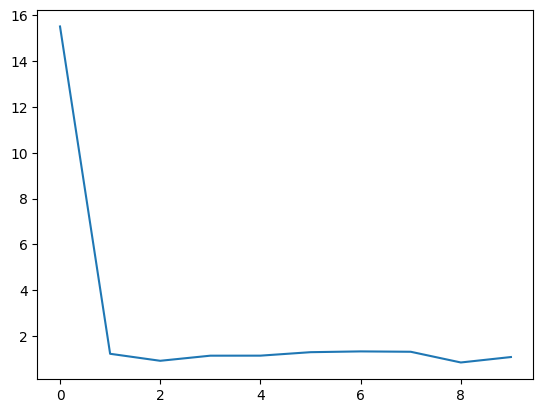

In [110]:
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        self.w1 = np.random.randn(input_size, hidden_size).astype('float32') * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size)).astype('float32')
        self.w2 = np.random.randn(hidden_size, hidden_size).astype('float32') * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, hidden_size)).astype('float32')
        self.w3 = np.random.randn(hidden_size, output_size).astype('float32') * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros((1, output_size)).astype('float32')

        self.x = None
        self.z1 = None
        self.z2 = None
        self.z3 = None
        self.a1 = None
        self.a2 = None
        self.a3 = None

    def relu(self, z):
        return np.maximum(z, 0)

    def relu_derivative(self, z):
        return (z > 0).astype('float32')

    def softmax(self, z):
        z = z - np.max(z, axis = 1, keepdims = True)
        return np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)

    def forward(self, x):
        self.x = x


        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = self.softmax(self.z3)

        return self.a3

    def compute_loss(self, y, y_hat):
        n = y.shape[0]

        eps = 1e-9

        neg_log = - np.log(y_hat[np.arange(n), y.astype(int)] + eps)

        return np.sum(neg_log) / n

    def backward(self, y, y_hat):
        n = y.shape[0]

        y_onehot = np.zeros_like(y_hat)
        y_onehot[np.arange(n),y.astype(int)] = 1

        dz3 = y_hat - y_onehot
        dw3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis = 0, keepdims = True)

        da2 = np.dot(dz3, self.w3.T)
        dz2 = da2 * self.relu_derivative(self.z2)
        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis = 0, keepdims = True)

        da1 = np.dot(dz2, self.w2.T)
        dz1 = da1 * self.relu_derivative(self.z1)
        dw1 = np.dot(self.x.T, dz1)
        db1 = np.sum(dz1, axis = 0, keepdims = True)

        grads = {
            'dw1': dw1,
            'dw2': dw2,
            'dw3': dw3,
            'db1': db1,
            'db2': db2,
            'db3': db3
        }

        return grads

    def train(self, lr, epochs, data_loader):
        loss_list = []
        for epoch in range(epochs):
            acc_loss = 0
            for x, y in data_loader:
                predictions = self.forward(x)

                loss = self.compute_loss(y, predictions)

                acc_loss += loss

                grads = self.backward(y, predictions)

                self.update_params(grads, lr)

            print(f'epoch: {epoch}, loss: {loss}')
            loss_list.append(loss)

        plt.plot(loss_list)
        plt.show()



    def update_params(self, grads, lr):
        self.w1 -= lr * grads['dw1']
        self.w2 -= lr * grads['dw2']
        self.w3 -= lr * grads['dw3']
        self.b1 -= lr * grads['db1']
        self.b2 -= lr * grads['db2']
        self.b3 -= lr * grads['db3']



model = Model(5, 128, 5)
model.train(lr=0.0001, epochs = 10, data_loader = train_loader)

In [111]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

all_y_true = []
all_y_pred = []

for x, y in test_loader:
    y_hat = model.forward(x)
    preds = np.argmax(y_hat, axis=1)
    y = y.astype(int)
    all_y_true.extend(y)
    all_y_pred.extend(preds)

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(all_y_true, all_y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, zero_division=0))




Evaluation Metrics:
Accuracy:  0.6500
Precision: 0.4833
Recall:    0.6500
F1 Score:  0.5518

Confusion Matrix:
[[ 0  0  0  0  6]
 [ 0  0  0  2  0]
 [ 0  0  0  0  2]
 [ 0  0  0  4  3]
 [ 0  0  0  1 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.57      0.57      0.57         7
           4       0.67      0.96      0.79        23

    accuracy                           0.65        40
   macro avg       0.25      0.31      0.27        40
weighted avg       0.48      0.65      0.55        40

